# Segmenting an image through superpixel classification

In [2]:
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
from skimage import io
import cv2
from multi_texton_histogram import MultiTexton
import glob 
import os
import random
import string
from skimage.transform import resize

Using TensorFlow backend.


Load up the before trained classifier:

In [10]:
classifier = load_model('segment_classification.h5')

## Image Paths 

We can try the segmentation algorithm on one sample image:

In [3]:
IMAGE_NAME = "0A1E4A42-41CB-47F6-AB97-68EAF6D7D2C3_431E50D4-9496-4480-902A-DE844638BFC1_000004"
IMG_PATH = '/home/daniel/Documents/data_science/data_cropped/gold/images/'
LABEL_PATH = '/home/daniel/Documents/data_science/data_cropped/gold/labels/'
FILE_NAME = os.path.join(IMG_PATH, IMAGE_NAME) + ".jpg"
LABEL_FILE_NAME = os.path.join(LABEL_PATH, IMAGE_NAME) + ".txt"

In [5]:
test_image = io.imread(FILE_NAME)

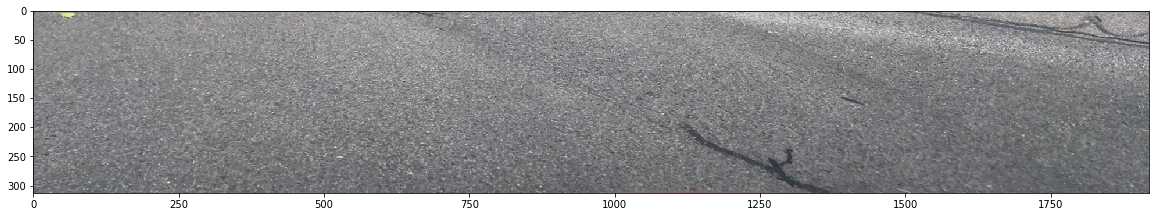

In [6]:
plt.figure(figsize=(20,25))
plt.imshow(test_image)

In [7]:
test_image = img_as_float(test_image)

## Apply the SLIC segmentation

We now go through every segment and classify it. We then mark evey segment depending on if it contains a Foreground or a Background class. The whole process is similar to the image saving routine, except for saving the segments, we classify them.

In [8]:
SEG_VAL = 50
N_SEGMENTS = 200

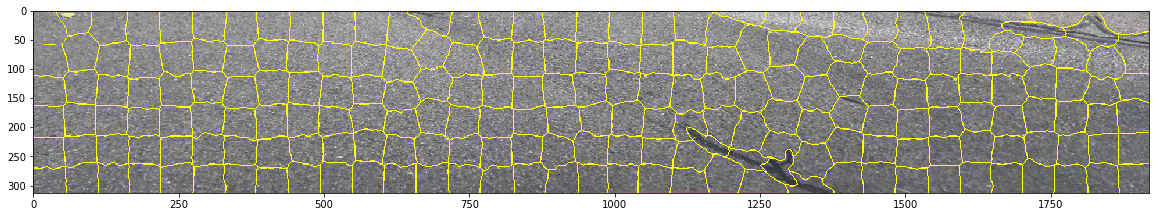

In [9]:
segments = slic(test_image, n_segments = N_SEGMENTS, sigma = 5)
plt.figure(figsize=(20,25))
plt.imshow(mark_boundaries(test_image, segments))

In [100]:
segmentation_mask = np.ones((img.shape[0], img.shape[1], 3))

In [105]:
img = img_as_float(test_image)
segs = slic(img, n_segments = N_SEGMENTS, sigma = 5)

for n_segment in range(N_SEGMENTS):

    # create a mask where only the segment is visible
    mask = np.zeros(img.shape[:2], dtype = "uint8")
    mask[segs == n_segment] = 255
    mask = cv2.bitwise_and(img, img, mask = mask)

    # crop out the segmented part
    segment_locations = np.argwhere(segs == n_segment)
    
    if len(segment_locations) > 0:
        x_min = np.min(segment_locations[:, 0])
        x_max = np.max(segment_locations[:, 0])
        y_min = np.min(segment_locations[:, 1])
        y_max = np.max(segment_locations[:, 1])

        cropped_mask = mask[x_min:x_max, y_min:y_max, :]
        cropped_mask = resize(cropped_mask, (50, 50), anti_aliasing=True)
        prediction = classifier.predict(np.expand_dims(cropped_mask, axis=0))
        
        for seg_coord in segment_locations:
            if prediction[0][0] > 0.8:
                segmentation_mask[seg_coord[0]][seg_coord[1], :] = 1
            else:
                segmentation_mask[seg_coord[0]][seg_coord[1], :] = 0
            

In [102]:
import cv2

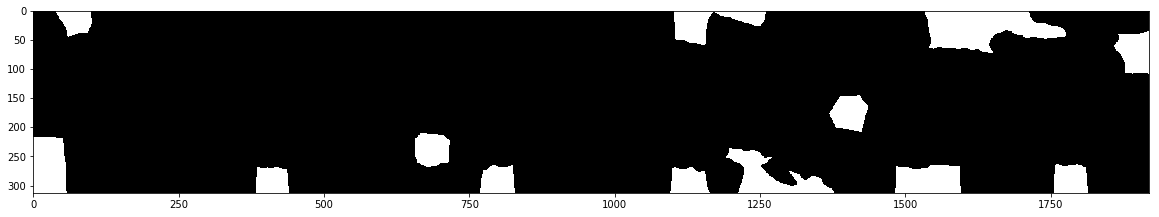

In [103]:
plt.figure(figsize=(20,25))
plt.imshow(segmentation_mask)

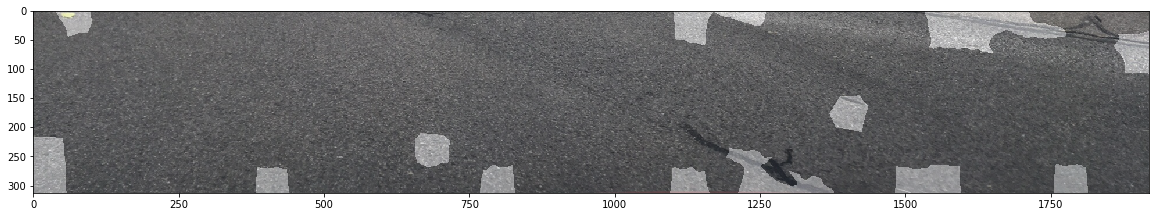

In [104]:
blended_image = 0.7 * img + 0.3 * segmentation_mask
plt.figure(figsize=(20,25))
plt.imshow(blended_image)

What we can see here is that the segmentation is not yet at the point at which it can be used in production. **Disclaimer**: This classifier wasn't trained on the preprocessed image data. Training it on the preprocessed image data could improve its performance dramatically, since a lot more damages are visible on that data. Another way of improving performance is to use larger segments, since a lot more context is visible on them. There are a lot of ways that can be explored to improve the performance of this model.